# Prototype: rho

| Properties      | Data    |
|---------------|-----------|
| *Dataset* | `NSL-KDD` |
| *Labels* | `ALL` |
| *Normalization* | `Min-Max` |
| *Sample Size* | `25.000`|
| *Adversarial Attack* | `FGSM & C&W & JSMA & PGD & Boundary & HSJ` |
| *Explanations* | `SHAP` |
| *Detector* | `Detect Attacks and Misclassified Samples` |


---

## *Setup*

In [21]:
# To import modules from the functions directory
import sys
import os
# Get current directory of script or notebook
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()

# Append parent directory (where "functions/" likely lives)
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)  # Make sure it's at the front

## Data Preprocessing

In [22]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
sample_size = 25000 # sample size for each label -> 2 x sample_size = total samples

dataset = dp.build_nsl_kdd_dataset()

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df, used_indices = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=sample_size, random_sample_state=3001)
print(f"Generate Features | Indices: {feature_df.index[:5]}... | Shape: {feature_df.shape}")
print(f"Generate Labels | Indices: {label_df.index[:5]}... | Shape: {label_df.shape}")
print(label_df.value_counts()) # -> will first show [0, 1] then [1, 0] if label number is equal

-- Building NSL-KDD dataset --


-- Generating normalizer --
--- Splitting labels and features ---
Numeric Features: Index([], dtype='object')
Zero Columns: ['num_outbound_cmds']
Zero Columns: Index(['num_outbound_cmds'], dtype='object')
Combined Zero Columns: ['num_outbound_cmds']
-- Preprocessing data --
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Sampling balanced data ---
Sample to shape: (50000, 40)
--- Normalizing features using MinMaxScaler ---
Generate Features | Indices: Index([65781, 110480, 141821, 44675, 77508], dtype='int64')... | Shape: (50000, 40)
Generate Labels | Indices: Index([65781, 110480, 141821, 44675, 77508], dtype='int64')... | Shape: (50000, 2)
BENIGN  ATTACK
False   True      25000
True    False     25000
Name: count, dtype: int64


## Split Data

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.1, random_state=31)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45000, 40) (5000, 40) (45000, 2) (5000, 2)


## Create IDS

In [24]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

# build ids and evaluate it on test data
ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)
# store prediction from X_train
y_pred = ids.predict(ids_model, X_train, columns=y_train.columns)
print(f"Predictions on Normal Data | Indices: {y_pred.index[:5]}... | Shape: {y_pred.shape}")

Epoch 1/20


900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8971 - loss: 0.2616 - val_accuracy: 0.9576 - val_loss: 0.1115
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.9616 - loss: 0.0995 - val_accuracy: 0.9631 - val_loss: 0.0886
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.9713 - loss: 0.0768 - val_accuracy: 0.9726 - val_loss: 0.0743
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.9768 - loss: 0.0637 - val_accuracy: 0.9756 - val_loss: 0.0661
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.9798 - loss: 0.0570 - val_accuracy: 0.9782 - val_loss: 0.0592
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.9813 - loss: 0.0523 - val_accuracy: 0.9803 - val_loss: 0.0549
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.9819 - loss: 0.0486 - val_accuracy: 0.9817 - val_loss: 0.0512
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.9828 - loss: 0.0457 - val_accuracy:

2025-07-09 20:07:01.203612: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step
Predictions on Normal Data | Indices: Index([137397, 114717, 117007, 108981, 145072], dtype='int64')... | Shape: (45000, 2)


## Generate Adversarial Attacks

In [ ]:
import functions.attack_generator as ag
import importlib
import numpy as np
importlib.reload(ag)

all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, X_train) # TODO: use all features for generating art model

# Split the training data into classes
class_labels = ["normal", "cw", "fgsm", "jsma", "pgd", "boundary", "hsj"]
splits = ag.split_into_attack_classes(X_train, y_train, class_labels)
X_normal, y_normal = splits["normal"]
X_cw, y_cw = splits["cw"]
X_fgsm, y_fgsm = splits["fgsm"]
X_jsma, y_jsma = splits["jsma"]
X_pgd, y_pgd = splits["pgd"]
X_boundary, y_boundary = splits["boundary"]
X_hsj, y_hsj = splits["hsj"]
print(f"Normal Data: {X_normal.shape} | CW Data: {X_cw.shape} | FGSM Data: {X_fgsm.shape} | JSMA Data: {X_jsma.shape} | PGD Data: {X_pgd.shape} | Boundary Data: {X_boundary.shape} | HSJ Data: {X_hsj.shape}")

# -- White-Box Attacks --
generate attacks on the separated training data
X_adv_fgsm = ag.generate_fgsm_attacks(art_model, X_fgsm)
print(f"Create FGSM Adversarial Attack | Indices: {X_adv_fgsm.index[:5]}... | Shape: {X_adv_fgsm.shape}")
y_pred_adv_fgsm = ag.evaluate_art_model(art_model, X_adv_fgsm, y_fgsm)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_fgsm.index[:5]}... | Shape: {y_pred_adv_fgsm.shape}")
y_pred_fgsm = y_pred.loc[X_fgsm.index]

import multiprocessing
num_cores = multiprocessing.cpu_count()
X_adv_cw = ag.generate_cw_attacks_parallel(art_model, X_cw, num_cores=num_cores-1)
print(f"Create CW Adversarial Attack | Indices: {X_adv_cw.index[:5]}... | Shape: {X_adv_cw.shape}")
y_pred_adv_cw = ag.evaluate_art_model(art_model, X_adv_cw, y_cw)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_cw.index[:5]}... | Shape: {y_pred_adv_cw.shape}")
y_pred_cw = y_pred.loc[X_cw.index]

X_adv_jsma = ag.generate_jsma_attacks(art_model, X_jsma)
print(f"Create JSMA Adversarial Attack | Indices: {X_adv_jsma.index[:5]}... | Shape: {X_adv_jsma.shape}")
y_pred_adv_jsma = ag.evaluate_art_model(art_model, X_adv_jsma, y_jsma)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_jsma.index[:5]}... | Shape: {y_pred_adv_jsma.shape}")
y_pred_jsma = y_pred.loc[X_jsma.index]

X_adv_pgd = ag.generate_pgd_attacks(art_model, X_pgd)
print(f"Create PGD Adversarial Attack | Indices: {X_adv_pgd.index[:5]}... | Shape: {X_adv_pgd.shape}")
y_pred_adv_pgd = ag.evaluate_art_model(art_model, X_adv_pgd, y_pgd)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_pgd.index[:5]}... | Shape: {y_pred_adv_pgd.shape}")
y_pred_pgd = y_pred.loc[X_pgd.index]

# -- Black-Box Attacks --
import pandas as pd
X_adv_hsj = ag.generate_hsj_attacks_parallel(art_model, X_hsj, num_cores=num_cores-1) # TODO: use num_cores-1 to avoid memory error
print(f"Create HSJ Adversarial Attack | Indices: {X_adv_hsj.index[:5]}... | Shape: {X_adv_hsj.shape}")
y_pred_adv_hsj = ag.evaluate_art_model(art_model, X_adv_hsj, y_hsj)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_hsj.index[:5]}... | Shape: {y_pred_adv_hsj.shape}")
y_pred_hsj = y_pred.loc[X_hsj.index]

X_adv_boundary = ag.generate_boundary_attacks_parallel(art_model, X_boundary, num_cores=num_cores)
print(f"Create Boundary Adversarial Attack | Indices: {X_adv_boundary.index[:5]}... | Shape: {X_adv_boundary.shape}")
y_pred_adv_boundary = ag.evaluate_art_model(art_model, X_adv_boundary, y_boundary)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_boundary.index[:5]}... | Shape: {y_pred_adv_boundary.shape}")
y_pred_boundary = y_pred.loc[X_adv_boundary.index]

Normal Data: (6432, 40) | CW Data: (6428, 40) | FGSM Data: (6428, 40) | JSMA Data: (6428, 40) | PGD Data: (6428, 40) | Boundary Data: (6428, 40) | HSJ Data: (6428, 40)


In [8]:
def get_correctly_benign_classified_indices(y_train, y_pred):
    benign_indices = y_train[y_train['BENIGN'] == 1].index
    benign_adv_predicted_indices = y_pred[y_pred['BENIGN'] == 1].index
    correctly_benign_classified_indices = benign_indices.intersection(benign_adv_predicted_indices)
    return correctly_benign_classified_indices

def get_misclassified_as_benign_due_attack_indices(y_train, y_pred, y_pred_adv):
    attack_indices = y_train[y_train['ATTACK'] == 1].index
    attack_adv_predicted_indices = y_pred[y_pred['ATTACK'] == 1].index
    benign_predicted_adversarial_indices = y_pred_adv[y_pred_adv['BENIGN'] == 1].index
    misclassified_as_benign_due_attack_indices = attack_indices.intersection(attack_adv_predicted_indices).intersection(benign_predicted_adversarial_indices)
    return misclassified_as_benign_due_attack_indices

def get_correctly_malicious_classified_indices(y_train, y_pred):
    malicious_indices = y_train[y_train['ATTACK'] == 1].index
    malicious_adv_predicted_indices = y_pred[y_pred['ATTACK'] == 1].index
    correctly_malicious_classified_indices = malicious_indices.intersection(malicious_adv_predicted_indices)
    return correctly_malicious_classified_indices

def get_misclassified_as_malicious_due_attack_indices(y_train, y_pred, y_pred_adv):
    benign_indices = y_train[y_train['BENIGN'] == 1].index
    benign_adv_predicted_indices = y_pred[y_pred['BENIGN'] == 1].index
    attack_predicted_adversarial_indices = y_pred_adv[y_pred_adv['ATTACK'] == 1].index
    misclassified_as_malicious_due_attack_indices = benign_indices.intersection(benign_adv_predicted_indices).intersection(attack_predicted_adversarial_indices)
    return misclassified_as_malicious_due_attack_indices

In [ ]:
y_pred_normal = y_pred.loc[X_normal.index]
correctly_benign_classified_indices = get_correctly_benign_classified_indices(y_normal, y_pred_normal)
misclassified_as_benign_indices = get_misclassified_as_benign_due_attack_indices(y_normal, y_normal, y_pred_normal)
correctly_malicious_classified_indices = get_correctly_malicious_classified_indices(y_normal, y_pred_normal)
misclassified_as_malicious_due_attack_indices = get_misclassified_as_malicious_due_attack_indices(y_normal, y_normal, y_pred_normal)

correctly_benign_classified_indices_fgsm = get_correctly_benign_classified_indices(y_fgsm, y_pred_adv_fgsm)
misclassified_as_benign_due_attack_indices_fgsm = get_misclassified_as_benign_due_attack_indices(y_fgsm, y_pred_fgsm, y_pred_adv_fgsm)
correctly_malicious_classified_indices_fgsm = get_correctly_malicious_classified_indices(y_fgsm, y_pred_fgsm)
misclassified_as_malicious_due_attack_indices_fgsm = get_misclassified_as_malicious_due_attack_indices(y_fgsm, y_pred_fgsm, y_pred_adv_fgsm)

correctly_benign_classified_indices_cw = get_correctly_benign_classified_indices(y_cw, y_pred_cw)
misclassified_as_benign_due_attack_indices_cw = get_misclassified_as_benign_due_attack_indices(y_cw, y_pred_cw, y_pred_adv_cw)
correctly_malicious_classified_indices_cw = get_correctly_malicious_classified_indices(y_cw, y_pred_cw)
misclassified_as_malicious_due_attack_indices_cw = get_misclassified_as_malicious_due_attack_indices(y_cw, y_pred_cw, y_pred_adv_cw)

correctly_benign_classified_indices_jsma = get_correctly_benign_classified_indices(y_jsma, y_pred_jsma)
misclassified_as_benign_due_attack_indices_jsma = get_misclassified_as_benign_due_attack_indices(y_jsma, y_pred_jsma, y_pred_adv_jsma)
correctly_malicious_classified_indices_jsma = get_correctly_malicious_classified_indices(y_jsma, y_pred_jsma)
misclassified_as_malicious_due_attack_indices_jsma = get_misclassified_as_malicious_due_attack_indices(y_jsma, y_pred_jsma, y_pred_adv_jsma)

correctly_benign_classified_indices_pgd = get_correctly_benign_classified_indices(y_pgd, y_pred_pgd)
misclassified_as_benign_due_attack_indices_pgd = get_misclassified_as_benign_due_attack_indices(y_pgd, y_pred_pgd, y_pred_adv_pgd)
correctly_malicious_classified_indices_pgd = get_correctly_malicious_classified_indices(y_pgd, y_pred_pgd)
misclassified_as_malicious_due_attack_indices_pgd = get_misclassified_as_malicious_due_attack_indices(y_pgd, y_pred_pgd, y_pred_adv_pgd)

correctly_benign_classified_indices_boundary = get_correctly_benign_classified_indices(y_boundary, y_pred_adv_boundary)
misclassified_as_benign_due_attack_indices_boundary = get_misclassified_as_benign_due_attack_indices(y_boundary, y_pred_boundary, y_pred_adv_boundary)
correctly_malicious_classified_indices_boundary = get_correctly_malicious_classified_indices(y_boundary, y_pred_boundary)
misclassified_as_malicious_due_attack_indices_boundary = get_misclassified_as_malicious_due_attack_indices(y_boundary, y_pred_boundary, y_pred_adv_boundary)

correctly_benign_classified_indices_hsj = get_correctly_benign_classified_indices(y_hsj, y_pred_hsj)
misclassified_as_benign_due_attack_indices_hsj = get_misclassified_as_benign_due_attack_indices(y_hsj, y_pred_hsj, y_pred_adv_hsj)
correctly_malicious_classified_indices_hsj = get_correctly_malicious_classified_indices(y_hsj, y_pred_hsj)
misclassified_as_malicious_due_attack_indices_hsj = get_misclassified_as_malicious_due_attack_indices(y_hsj, y_pred_hsj, y_pred_adv_hsj)

print(f"Correctly classified as BENIGN from the IDS: {len(correctly_benign_classified_indices)} | Indices: {correctly_benign_classified_indices[:3]}")
print(f"ATTACK sample misclassified as BENIGN from the IDS: {len(misclassified_as_benign_indices)} | Indices: {misclassified_as_benign_indices[:3]}")
print(f"Correctly classified as ATTACK from the IDS: {len(correctly_malicious_classified_indices)} | Indices: {correctly_malicious_classified_indices[:3]}")
print(f"ATTACK sample misclassified as ATTACK from the IDS: {len(misclassified_as_malicious_due_attack_indices)} | Indices: {misclassified_as_malicious_due_attack_indices[:3]}")
print(f"    Correctly classified as BENIGN from the IDS (FGSM): {len(correctly_benign_classified_indices_fgsm)} | Indices: {correctly_benign_classified_indices_fgsm[:3]}")
print(f"    ATTACK sample misclassified as BENIGN due to adversarial attack (FGSM): {len(misclassified_as_benign_due_attack_indices_fgsm)} | Indices: {misclassified_as_benign_due_attack_indices_fgsm[:3]}")
print(f"    Correctly classified as ATTACK from the IDS (FGSM): {len(correctly_malicious_classified_indices_fgsm)} | Indices: {correctly_malicious_classified_indices_fgsm[:3]}")
print(f"    ATTACK sample misclassified as ATTACK due to adversarial attack (FGSM): {len(misclassified_as_malicious_due_attack_indices_fgsm)} | Indices: {misclassified_as_malicious_due_attack_indices_fgsm[:3]}")
print(f"        Correctly classified as BENIGN from the IDS (CW): {len(correctly_benign_classified_indices_cw)} | Indices: {correctly_benign_classified_indices_cw[:3]}")
print(f"        ATTACK sample misclassified as BENIGN due to adversarial attack (CW): {len(misclassified_as_benign_due_attack_indices_cw)} | Indices: {misclassified_as_benign_due_attack_indices_cw[:3]}")
print(f"        Correctly classified as ATTACK from the IDS (CW): {len(correctly_malicious_classified_indices_cw)} | Indices: {correctly_malicious_classified_indices_cw[:3]}")
print(f"        ATTACK sample misclassified as ATTACK due to adversarial attack (CW): {len(misclassified_as_malicious_due_attack_indices_cw)} | Indices: {misclassified_as_malicious_due_attack_indices_cw[:3]}")
print(f"            Correctly classified as BENIGN from the IDS (PGD): {len(correctly_benign_classified_indices_pgd)} | Indices: {correctly_benign_classified_indices_pgd[:3]}")
print(f"            ATTACK sample misclassified as BENIGN due to adversarial attack (PGD): {len(misclassified_as_benign_due_attack_indices_pgd)} | Indices: {misclassified_as_benign_due_attack_indices_pgd[:3]}")
print(f"            Correctly classified as ATTACK from the IDS (PGD): {len(correctly_malicious_classified_indices_pgd)} | Indices: {correctly_malicious_classified_indices_pgd[:3]}")
print(f"            ATTACK sample misclassified as ATTACK due to adversarial attack (PGD): {len(misclassified_as_malicious_due_attack_indices_pgd)} | Indices: {misclassified_as_malicious_due_attack_indices_pgd[:3]}")
print(f"                Correctly classified as BENIGN from the IDS (JSMA): {len(correctly_benign_classified_indices_jsma)} | Indices: {correctly_benign_classified_indices_jsma[:3]}")
print(f"                ATTACK sample misclassified as BENIGN due to adversarial attack (JSMA): {len(misclassified_as_benign_due_attack_indices_jsma)} | Indices: {misclassified_as_benign_due_attack_indices_jsma[:3]}")
print(f"                Correctly classified as ATTACK from the IDS (JSMA): {len(correctly_malicious_classified_indices_jsma)} | Indices: {correctly_malicious_classified_indices_jsma[:3]}")
print(f"                ATTACK sample misclassified as ATTACK due to adversarial attack (JSMA): {len(misclassified_as_malicious_due_attack_indices_jsma)} | Indices: {misclassified_as_malicious_due_attack_indices_jsma[:3]}")
print(f"                    Correctly classified as BENIGN from the IDS (Boundary): {len(correctly_benign_classified_indices_boundary)} | Indices: {correctly_benign_classified_indices_boundary[:3]}")
print(f"                    ATTACK sample misclassified as BENIGN due to adversarial attack (Boundary): {len(misclassified_as_benign_due_attack_indices_boundary)} | Indices: {misclassified_as_benign_due_attack_indices_boundary[:3]}")
print(f"                    Correctly classified as ATTACK from the IDS (Boundary): {len(correctly_malicious_classified_indices_boundary)} | Indices: {correctly_malicious_classified_indices_boundary[:3]}")
print(f"                    ATTACK sample misclassified as ATTACK due to adversarial attack (Boundary): {len(misclassified_as_malicious_due_attack_indices_boundary)} | Indices: {misclassified_as_malicious_due_attack_indices_boundary[:3]}")
print(f"                        Correctly classified as BENIGN from the IDS (HSJ): {len(correctly_benign_classified_indices_hsj)} | Indices: {correctly_benign_classified_indices_hsj[:3]}")
print(f"                        ATTACK sample misclassified as BENIGN due to adversarial attack (HSJ): {len(misclassified_as_benign_due_attack_indices_hsj)} | Indices: {misclassified_as_benign_due_attack_indices_hsj[:3]}")
print(f"                        Correctly classified as ATTACK from the IDS (HSJ): {len(correctly_malicious_classified_indices_hsj)} | Indices: {correctly_malicious_classified_indices_hsj[:3]}")
print(f"                        ATTACK sample misclassified as ATTACK due to adversarial attack (HSJ): {len(misclassified_as_malicious_due_attack_indices_hsj)} | Indices: {misclassified_as_malicious_due_attack_indices_hsj[:3]}")

Correctly classified as BENIGN from the IDS: 3231 | Indices: Index([79776, 11148, 118024], dtype='int64')
ATTACK sample misclassified as BENIGN from the IDS: 32 | Indices: Index([59752, 132912, 145647], dtype='int64')
Correctly classified as ATTACK from the IDS: 3134 | Indices: Index([97569, 94920, 84732], dtype='int64')
ATTACK sample misclassified as ATTACK from the IDS: 35 | Indices: Index([43426, 49716, 147580], dtype='int64')
    Correctly classified as BENIGN from the IDS (FGSM): 30 | Indices: Index([48950, 61729, 127919], dtype='int64')
    ATTACK sample misclassified as BENIGN due to adversarial attack (FGSM): 2963 | Indices: Index([41876, 92955, 90098], dtype='int64')
    Correctly classified as ATTACK from the IDS (FGSM): 3218 | Indices: Index([41876, 92955, 90098], dtype='int64')
    ATTACK sample misclassified as ATTACK due to adversarial attack (FGSM): 3133 | Indices: Index([7397, 147461, 41902], dtype='int64')
        Correctly classified as BENIGN from the IDS (CW): 3174 

In [9]:
# import functions.visualizer as visualizer
# import importlib
# importlib.reload(visualizer)

# visualizer.visualize_data_distribution(X_train.loc[correctly_benign_classified_indices], 'Normal Data', X_adv_fgsm.loc[correctly_benign_classified_indices_fgsm], 'Adversarial Data')
# visualizer.visualize_data_distribution(X_train.loc[correctly_benign_classified_indices], 'Normal Data', X_adv_cw.loc[correctly_benign_classified_indices_cw], 'Adversarial Data')
# visualizer.visualize_data_distribution(X_train.loc[misclassified_as_malicious_due_attack_indices], 'Normal Data', X_adv_cw.loc[misclassified_as_malicious_due_attack_indices_cw], 'Adversarial Data')

## Explainer

In [ ]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values_df = exp.generate_shap_values(explainer, X_normal)
print(f"Generate Explanations | Indices: {shap_values_df.index[:5]}... | Shape: {shap_values_df.shape}")

shap_values_adv_df_fgsm = exp.generate_shap_values(explainer, X_adv_fgsm)
print(f"Generate FGSM Adversarial Explanations | Indices: {shap_values_adv_df_fgsm.index[:5]}... | Shape: {shap_values_adv_df_fgsm.shape}")

shap_values_adv_df_cw = exp.generate_shap_values(explainer, X_adv_cw)
print(f"Generate CW Adversarial Explanations | Indices: {shap_values_adv_df_cw.index[:5]}... | Shape: {shap_values_adv_df_cw.shape}")

shap_values_adv_df_jsma = exp.generate_shap_values(explainer, X_adv_jsma)
print(f"Generate JSMA Adversarial Explanations | Indices: {shap_values_adv_df_jsma.index[:5]}... | Shape: {shap_values_adv_df_jsma.shape}")

shap_values_adv_df_pgd = exp.generate_shap_values(explainer, X_adv_pgd)
print(f"Generate PGD Adversarial Explanations | Indices: {shap_values_adv_df_pgd.index[:5]}... | Shape: {shap_values_adv_df_pgd.shape}")

shap_values_adv_df_boundary = exp.generate_shap_values(explainer, X_adv_boundary)
print(f"Generate Boundary Adversarial Explanations | Indices: {shap_values_adv_df_boundary.index[:5]}... | Shape: {shap_values_adv_df_boundary.shape}")

shap_values_adv_df_hsj = exp.generate_shap_values(explainer, X_adv_hsj)
print(f"Generate HSJ Adversarial Explanations | Indices: {shap_values_adv_df_hsj.index[:5]}... | Shape: {shap_values_adv_df_hsj.shape}")

PermutationExplainer explainer: 6433it [02:52, 35.91it/s]                                                                                                                                                                  


Generate Explanations | Indices: Index([79776, 11148, 97569, 118024, 94920], dtype='int64')... | Shape: (6432, 40)


PermutationExplainer explainer: 6429it [03:09, 32.33it/s]                                                                                                                                                                  


Generate FGSM Adversarial Explanations | Indices: Index([7397, 41876, 147461, 147405, 92955], dtype='int64')... | Shape: (6428, 40)


PermutationExplainer explainer: 6429it [03:03, 33.25it/s]                                                                                                                                                                  


Generate CW Adversarial Explanations | Indices: Index([94924, 133782, 144885, 29954, 19191], dtype='int64')... | Shape: (6428, 40)


PermutationExplainer explainer: 6429it [02:58, 34.00it/s]                                                                                                                                                                  


Generate JSMA Adversarial Explanations | Indices: Index([16143, 22497, 79362, 6627, 84688], dtype='int64')... | Shape: (6428, 40)


PermutationExplainer explainer: 6429it [03:07, 32.49it/s]                                                                                                                                                                  


Generate PGD Adversarial Explanations | Indices: Index([115920, 33653, 88735, 109128, 54140], dtype='int64')... | Shape: (6428, 40)


In [11]:
# store shap values
shap_values_df.to_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values.csv", index=False)
shap_values_adv_df_fgsm.to_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_fgsm.csv", index=False)
shap_values_adv_df_cw.to_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_cw.csv", index=False)
shap_values_adv_df_jsma.to_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_jsma.csv", index=False)
shap_values_adv_df_pgd.to_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_pgd.csv", index=False)
shap_values_adv_df_boundary.to_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_boundary.csv", index=False)
shap_values_adv_df_hsj.to_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_hsj.csv", index=False)

In [8]:
# load shap values
import pandas as pd
shap_values_df = pd.read_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values.csv")
shap_values_adv_df_fgsm = pd.read_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_fgsm.csv")
shap_values_adv_df_cw = pd.read_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_cw.csv")
shap_values_adv_df_jsma = pd.read_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_jsma.csv")
shap_values_adv_df_pgd = pd.read_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_pgd.csv")
shap_values_adv_df_boundary = pd.read_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_boundary.csv")
shap_values_adv_df_hsj = pd.read_csv("../../datasets/CICIDS2017/shap_values/pi-shap_values_adv_hsj.csv")

In [13]:
# import functions.visualizer as visualizer
# import importlib
# importlib.reload(visualizer)

# visualizer.visualize_data_distribution(shap_values_df.loc[correctly_benign_classified_indices], 'Normal Explanations', shap_values_adv_df_fgsm.loc[misclassified_as_benign_due_attack_indices_fgsm], 'Adversarial Explanations')

In [14]:
# exp.plot_shap_summary_comparison(shap_values_df.loc[correctly_benign_classified_indices].values, X_train.loc[correctly_benign_classified_indices], shap_values_adv_df.loc[misclassified_as_benign_due_attack_indices].values, X_adv.loc[misclassified_as_benign_due_attack_indices], 6, title='Normal vs Adversarial Explanations of Benign Samples')

In [ ]:
import pandas as pd
adv_concat_correctly_benign_classified_shaps = pd.concat([
    shap_values_adv_df_fgsm.loc[correctly_benign_classified_indices_fgsm],
    shap_values_adv_df_pgd.loc[correctly_benign_classified_indices_pgd],
    shap_values_adv_df_cw.loc[correctly_benign_classified_indices_cw],
    shap_values_adv_df_jsma.loc[correctly_benign_classified_indices_jsma],
    shap_values_adv_df_fgsm.loc[misclassified_as_malicious_due_attack_indices_fgsm], 
    shap_values_adv_df_pgd.loc[misclassified_as_malicious_due_attack_indices_pgd],
    shap_values_adv_df_cw.loc[misclassified_as_malicious_due_attack_indices_cw],
    shap_values_adv_df_jsma.loc[misclassified_as_malicious_due_attack_indices_jsma],
    # shap_values_df.loc[correctly_benign_classified_indices], # TODO: test without them in a 4-class classification
    ], axis=0)

# adv_concat_misclassified_as_benign_shaps = pd.concat([
#     shap_values_adv_df_fgsm.loc[misclassified_as_benign_due_attack_indices_fgsm], 
#     shap_values_adv_df_pgd.loc[misclassified_as_benign_due_attack_indices_pgd],
#     shap_values_adv_df_cw.loc[misclassified_as_benign_due_attack_indices_cw],
#     shap_values_adv_df_jsma.loc[misclassified_as_benign_due_attack_indices_jsma]
#     ], axis=0)

adv_concat_correctly_malicious_classified_shaps = pd.concat([
    shap_values_adv_df_fgsm.loc[correctly_malicious_classified_indices_fgsm], 
    shap_values_adv_df_pgd.loc[correctly_malicious_classified_indices_pgd],
    shap_values_adv_df_cw.loc[correctly_malicious_classified_indices_cw],
    shap_values_adv_df_jsma.loc[correctly_malicious_classified_indices_jsma],
    shap_values_adv_df_fgsm.loc[misclassified_as_benign_due_attack_indices_fgsm], 
    shap_values_adv_df_pgd.loc[misclassified_as_benign_due_attack_indices_pgd],
    shap_values_adv_df_cw.loc[misclassified_as_benign_due_attack_indices_cw],
    shap_values_adv_df_jsma.loc[misclassified_as_benign_due_attack_indices_jsma],
    # shap_values_df.loc[correctly_malicious_classified_indices], # TODO: test without them in a 4-class classification
    ], axis=0)

# adv_concat_misclassified_as_malicious_shaps = pd.concat([
#     shap_values_adv_df_fgsm.loc[misclassified_as_malicious_due_attack_indices_fgsm], 
#     shap_values_adv_df_pgd.loc[misclassified_as_malicious_due_attack_indices_pgd],
#     shap_values_adv_df_cw.loc[misclassified_as_malicious_due_attack_indices_cw],
#     shap_values_adv_df_jsma.loc[misclassified_as_malicious_due_attack_indices_jsma]
#     ], axis=0)

concat_correct_benign_shaps = pd.concat([
    shap_values_df.loc[correctly_benign_classified_indices], 
    ], axis=0)

concat_correct_attack_shaps = pd.concat([
    shap_values_df.loc[correctly_malicious_classified_indices],
    ], axis=0)

print(f" ADV Correctly BENIGN : {adv_concat_correctly_benign_classified_shaps.shape} | ADV Correctly ATTACK: {adv_concat_correctly_malicious_classified_shaps.shape} | BENIGN: {concat_correct_benign_shaps.shape} | ATTACK: {concat_correct_attack_shaps.shape}")

 ADV Correctly BENIGN : (20010, 40) | ADV Correctly ATTACK: (20691, 40) | BENIGN: (3231, 40) | ATTACK: (3134, 40)


## Detector

In [ ]:
import functions.detector as det
import importlib
importlib.reload(det)

# create dataframe
class_samples = {
    'ADV CORRECT ATTACK': adv_concat_correctly_malicious_classified_shaps,
    'ADV CORRECT BENIGN': adv_concat_correctly_benign_classified_shaps,
    'CORRECT BENIGN': concat_correct_benign_shaps, 
    'CORRECT ATTACK': concat_correct_attack_shaps,
}
X, y = det.build_detector_dataset(class_samples)
print(X.shape, y.shape)

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)

# store detector
det.store(detector, 'rho')

Generated dataset: X shape (47066, 40), y shape (47066, 4)
(47066, 40) (47066, 4)
(42359, 40) (4707, 40) (42359, 4) (4707, 4)
Epoch 1/20


2025-04-28 14:25:04.210194: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


848/848 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7154 - loss: 0.7067 - val_accuracy: 0.8729 - val_loss: 0.2450
Epoch 2/20
848/848 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8598 - loss: 0.2723 - val_accuracy: 0.8810 - val_loss: 0.2294
Epoch 3/20
848/848 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.8679 - loss: 0.2486 - val_accuracy: 0.8831 - val_loss: 0.2203
Epoch 4/20
848/848 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8686 - loss: 0.2432 - val_accuracy: 0.8837 - val_loss: 0.2139
Epoch 5/20
848/848 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8713 - loss: 0.2326 - val_accuracy: 0.8874 - val_loss: 0.2057
Epoch 6/20
848/848 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8748 - loss: 0.2245 - val_accuracy: 0.8894 - val_loss: 0.2016
Epoch 7/20
848/848 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.8741 - loss: 0.2189 - val_accuracy: 0.8896 - val_loss: 0.1998
Epoch 8/20
848/848 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8758 - loss: 0.2162 - val_accuracy: 0.8906 - 

2025-04-28 14:25:24.126255: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [13]:
# Evaluate detector
y_pred_det = det.predict(detector, X_test_det, y.columns)
print(f"Predictions on Detector | Indices: {y_pred_det.index[:5]}... | Shape: {y_pred_det.shape}")

# Convert one-hot to class indices
y_true_indices = np.argmax(y_test_det, axis=1)
y_true_indices_pd = pd.Series(y_true_indices, index=y_test_det.index)
y_pred_indices = np.argmax(y_pred_det, axis=1)
y_pred_indices_pd = pd.Series(y_pred_indices, index=y_pred_det.index)
print(y_true_indices[:5], y_pred_indices[:5])

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Compute Accuracy
accuracy = accuracy_score(y_true_indices, y_pred_indices)
print(f"Overall Accuracy: {accuracy:.4f}")

# Compute Classification Report for overall classification
print("Classification Report (Overall):")
print(classification_report(y_true_indices, y_pred_indices, target_names=y.columns, zero_division=0, digits=4))

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
Predictions on Detector | Indices: Index([12212, 104327, 44898, 4570, 20768], dtype='int64')... | Shape: (4707, 4)
[1 1 1 0 1] [2 1 1 3 2]
Overall Accuracy: 0.8853
Classification Report (Overall):
                    precision    recall  f1-score   support

ADV CORRECT ATTACK     0.9347    0.9271    0.9309      2099
ADV CORRECT BENIGN     0.9932    0.8763    0.9311      2013
    CORRECT BENIGN     0.5527    0.9771    0.7060       306
    CORRECT ATTACK     0.5130    0.5467    0.5293       289

          accuracy                         0.8853      4707
         macro avg     0.7484    0.8318    0.7743      4707
      weighted avg     0.9090    0.8853    0.8917      4707



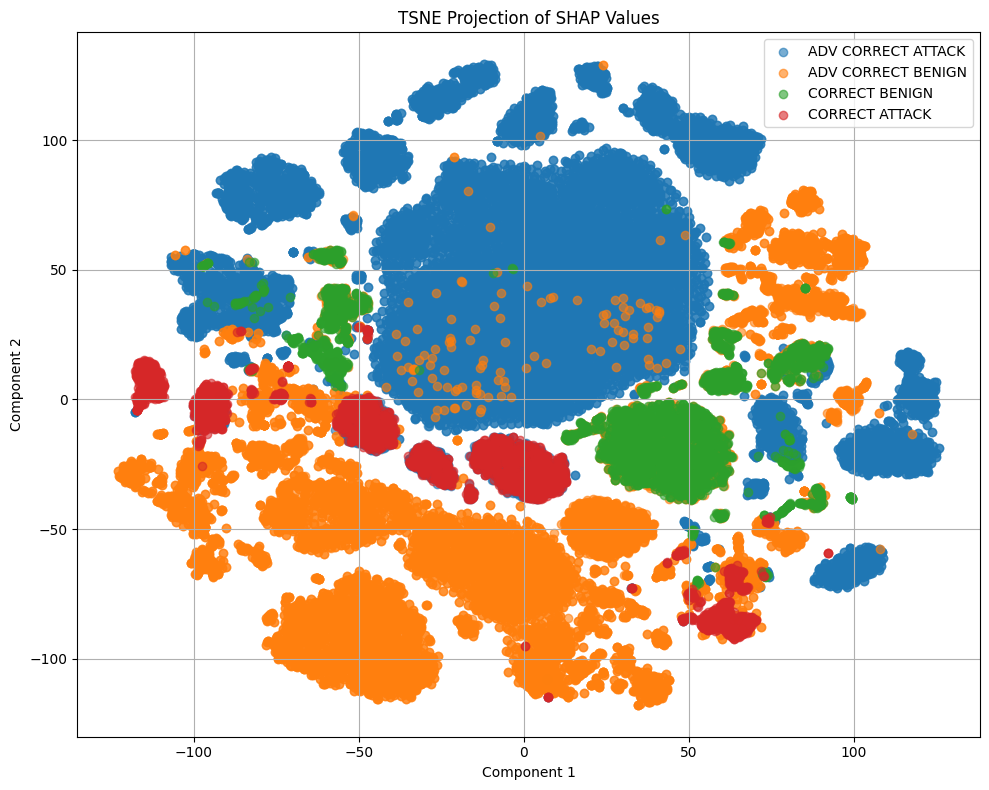

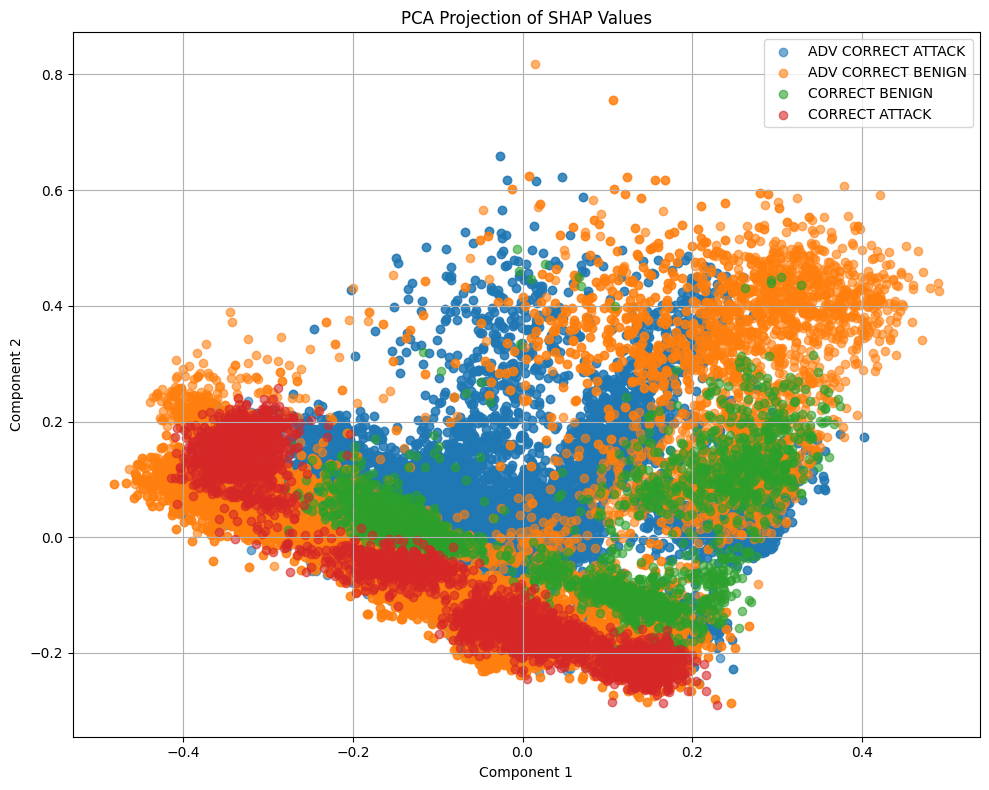

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


# Optional: UMAP (must be installed separately)
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False

def plot_dim_reduction(X, y_onehot, class_labels, method="pca", **kwargs):
    """
    Plots dimensionality-reduced data using PCA, t-SNE, or UMAP.

    Args:
        X (ndarray or DataFrame): Feature matrix.
        y_onehot (ndarray): One-hot encoded labels.
        class_labels (list of str): Class label names.
        method (str): 'pca', 'tsne', or 'umap'.
        **kwargs: Additional arguments for the reducer (e.g., perplexity for t-SNE).
    """
    y_indices = np.argmax(y_onehot, axis=1)

    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, **kwargs)
    elif method == "umap":
        if not UMAP_AVAILABLE:
            raise ImportError("UMAP is not installed. Run: pip install umap-learn")
        reducer = umap.UMAP(n_components=2, random_state=42, **kwargs)
    else:
        raise ValueError("Invalid method. Choose from 'pca', 'tsne', or 'umap'.")

    X_reduced = reducer.fit_transform(X)

    # Plot
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_labels):
        idx = y_indices == i
        plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], label=label, alpha=0.6)

    plt.title(f"{method.upper()} Projection of SHAP Values")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Choose method: 'pca', 'tsne', or 'umap'
plot_dim_reduction(X, y, class_samples, method="tsne", perplexity=30)
plot_dim_reduction(X, y, class_samples, method="pca")

---
## Manual Evaluation
We perform the whole two-stages approach on new unseen data and evaluate the following scores:
- Recall
- Precision
- Accuracy
- F1 Score

In [14]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

# exclude previously used samples
dataset_eval_excluded = dataset.drop(index=used_indices)

X_eval, y_eval, used_eval_indices = dp.preprocess_data(dataset_eval_excluded, encoding_type, normalizer, zero_columns, sample_size=1000, random_sample_state=17)
print(f"Generate Features | Indices: {X_eval.index[:5]}... | Shape: {X_eval.shape}")
print(f"Generate Labels | Indices: {y_eval.index[:5]}... | Shape: {y_eval.shape}")
print(y_eval.value_counts())

-- Preprocessing data --
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Sampling balanced data ---
Sample to shape: (2000, 40)
--- Normalizing features using MinMaxScaler ---
Generate Features | Indices: Index([68523, 129785, 117976, 50018, 32492], dtype='int64')... | Shape: (2000, 40)
Generate Labels | Indices: Index([68523, 129785, 117976, 50018, 32492], dtype='int64')... | Shape: (2000, 2)
BENIGN  ATTACK
False   True      1000
True    False     1000
Name: count, dtype: int64


### Load Detector etc.

In [31]:
import functions.detector as det
import functions.explainer as exp
import functions.attack_generator as ag
importlib.reload(det)
import numpy as np
detector = det.load('pi')

explainer = exp.generate_shap_explainer(ids_model, X_train)

all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, X_train) # TODO: use all features for generating art model

import multiprocessing
num_cores = multiprocessing.cpu_count()

### Normal IDS Prediction

In [15]:
y_pred_norm = ids.predict(ids_model, X_eval, y_eval.columns)
ids.evaluate_model(y_pred_norm, y_eval)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


Global Accuracy: 98.65%
              precision    recall  f1-score   support

      ATTACK     0.9919    0.9810    0.9864      1000
      BENIGN     0.9812    0.9920    0.9866      1000

    accuracy                         0.9865      2000
   macro avg     0.9866    0.9865    0.9865      2000
weighted avg     0.9866    0.9865    0.9865      2000



2025-04-28 14:25:42.518348: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [16]:
importlib.reload(ag)

X_adv_eval = ag.generate_cw_attacks_parallel(art_model, X_eval, num_cores=num_cores)
print(f"Create Adversarial Attack | Indices: {X_adv_eval.index[:5]}... | Shape: {X_adv_eval.shape}")

y_pred_adv_eval = ag.evaluate_art_model(art_model, X_adv_eval, y_eval)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_eval.index[:5]}... | Shape: {y_pred_adv_eval.shape}")

Running attack using 24 CPU cores...

Process 40697 is generating adversarial examples for batch of size 83 
Process 40702 is generating adversarial examples for batch of size 83 
Process 40696 is generating adversarial examples for batch of size 83 
Process 40698 is generating adversarial examples for batch of size 83 
Process 40700 is generating adversarial examples for batch of size 83 
Process 40699 is generating adversarial examples for batch of size 83 
Process 40701 is generating adversarial examples for batch of size 83 
Process 40705 is generating adversarial examples for batch of size 83 
Process 40706 is generating adversarial examples for batch of size 83 
Process 40703 is generating adversarial examples for batch of size 83 
Process 40707 is generating adversarial examples for batch of size 83 
Process 40704 is generating adversarial examples for batch of size 83 
Process 40708 is generating adversarial examples for batch of size 83 
Process 40709 is generating adversarial

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/83 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/91 [00:00<?, ?it/s]

Create Adversarial Attack | Indices: Index([68523, 129785, 117976, 50018, 32492], dtype='int64')... | Shape: (2000, 40)
Accuracy: 78.60%
              precision    recall  f1-score   support

      ATTACK     0.7581    0.8400    0.7970      1000
      BENIGN     0.8206    0.7320    0.7738      1000

    accuracy                         0.7860      2000
   macro avg     0.7894    0.7860    0.7854      2000
weighted avg     0.7894    0.7860    0.7854      2000

Confusion Matrix: Positive == BENIGN
TN: 840, FP: 160, FN: 268, TP: 732
Predictions on Adversarial Attacks | Indices: Index([68523, 129785, 117976, 50018, 32492], dtype='int64')... | Shape: (2000, 2)


In [17]:
importlib.reload(exp)
X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_eval)

print(f"Create Explanations | Indices: {X_eval_adv_shap_values_df.index[:5]}... | Shape: {X_eval_adv_shap_values_df.shape}")

PermutationExplainer explainer: 2001it [00:55, 29.75it/s]                                                                                                                                                                  

Create Explanations | Indices: Index([68523, 129785, 117976, 50018, 32492], dtype='int64')... | Shape: (2000, 40)


In [ ]:
# # normal shap values
# y_pred_adv_eval = ag.evaluate_art_model(art_model, X_eval, y_eval)
# print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_eval.index[:5]}... | Shape: {y_pred_adv_eval.shape}")

# X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_eval)

# print(f"Create Explanations | Indices: {X_eval_adv_shap_values_df.index[:5]}... | Shape: {X_eval_adv_shap_values_df.shape}")

In [18]:
importlib.reload(det)
benign_eval_idx = y_eval[y_eval['BENIGN'] == 1].index
attack_eval_idx = y_eval[y_eval['ATTACK'] == 1].index

pred_benign_idx = y_pred_adv_eval[y_pred_adv_eval['BENIGN'] == 1].index
pred_attack_idx = y_pred_adv_eval[y_pred_adv_eval['ATTACK'] == 1].index

# predict
columns = ['ADV CORRECT ATTACK', 'ADV CORRECT BENIGN', 'CORRECT BENIGN', 'CORRECT ATTACK']
y_pred_eval_detector = det.predict(detector, X_eval_adv_shap_values_df, columns)

# correctly_classified_det_idx = y_pred_eval_detector[y_pred_eval_detector['BENIGN'] == 1].index
# misclassified_det_idx = y_pred_eval_detector[y_pred_eval_detector['ATTACK'] == 1].index

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


2025-04-28 14:34:20.381711: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [19]:
pred_class_0 = y_pred_eval_detector[y_pred_eval_detector['ADV CORRECT BENIGN'] == 1].index 
pred_class_1 = y_pred_eval_detector[y_pred_eval_detector['ADV CORRECT ATTACK'] == 1].index
pred_class_2 = y_pred_eval_detector[y_pred_eval_detector['CORRECT ATTACK'] == 1].index
pred_class_3 = y_pred_eval_detector[y_pred_eval_detector['CORRECT BENIGN'] == 1].index
print(f"Predicted Class 0: {len(pred_class_0)}")
print(f"Predicted Class 1: {len(pred_class_1)}")
print(f"Predicted Class 2: {len(pred_class_2)}")
print(f"Predicted Class 3: {len(pred_class_3)}")
print("All Predicted Classes: ", len(pred_class_0) + len(pred_class_1) + len(pred_class_2) + len(pred_class_3))

Predicted Class 0: 281
Predicted Class 1: 543
Predicted Class 2: 438
Predicted Class 3: 738
All Predicted Classes:  2000


### ROC Curve

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


[[5.1938564e-01 4.9826379e-08 6.6062031e-11 4.8061427e-01]
 [1.2574212e-04 9.9982548e-01 7.0798133e-06 4.1723306e-05]
 [5.0806111e-01 2.0003022e-06 1.2116845e-08 4.9193686e-01]
 [5.1521337e-01 2.5317652e-07 6.5406630e-10 4.8478627e-01]
 [5.0710315e-01 4.2304313e-07 1.1900250e-09 4.9289641e-01]]
(2000, 4)
[9.9999988e-01 1.6746543e-04 9.9999797e-01 9.9999964e-01 9.9999952e-01]
[1 1 1 1 1]
(2000,)
At TPR=0.950, FPR=0.016, threshold=0.667


2025-04-28 14:34:36.055378: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


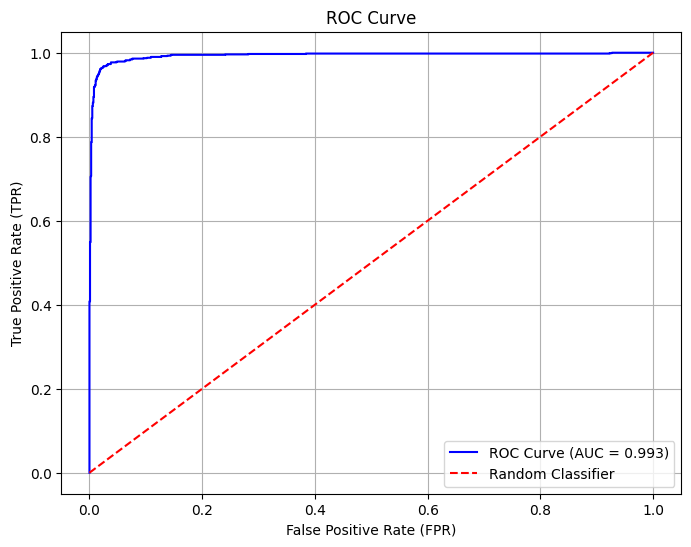

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_roc = detector.predict(X_eval_adv_shap_values_df)
print(y_pred_roc[:5])
print(y_pred_roc.shape)
# sum up class 0 and 3
y_score = y_pred_roc[:, 0] + y_pred_roc[:, 3]
print(y_score[:5])

y_benign = np.argmax(y_eval, axis=1)
print(y_benign[:5])
print(y_benign.shape)


# Compute ROC
fpr, tpr, thresholds = roc_curve(y_benign, y_score)

# Find TPR ~ 0.95
target_tpr = 0.95
idx = (np.abs(tpr - target_tpr)).argmin()

print(f"At TPR={tpr[idx]:.3f}, FPR={fpr[idx]:.3f}, threshold={thresholds[idx]:.3f}")

# Step 2: Calculate AUC
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC curve
plt.figure(figsize=(8, 6))  # Set figure size

# Plot the ROC curve with AUC in the legend
plt.plot(fpr, tpr, color='b', label='ROC Curve (AUC = {:.3f})'.format(roc_auc))

# Add the diagonal line (random classifier) for reference
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Random Classifier')

# Labeling the axes and adding a title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')

# Add legend
plt.legend(loc='lower right')

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [20]:
# TODO: define correct and misclassified classes for each attack:
benign_pred_idx = y_pred_eval_detector.loc[pred_class_0].index # Detector classifies 'BENIGN' samples as correct 'BENIGN'
attack_pred_idx = y_pred_eval_detector.loc[pred_class_1].index # Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK'

# generate bening_pred_idx: pred_class_0 and 3 are benign
benign_pred_idx = np.concatenate([y_pred_eval_detector.loc[pred_class_0].index, y_pred_eval_detector.loc[pred_class_3].index]) # Detector classifies 'BENIGN' samples as correct 'BENIGN'
# generate attack_pred_idx: pred_class_1 and 2 are attack
attack_pred_idx = np.concatenate([y_pred_eval_detector.loc[pred_class_1].index, y_pred_eval_detector.loc[pred_class_2].index]) # Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK'

# After Detector Stage
TP = len(benign_eval_idx.intersection(benign_pred_idx)) # Detector classifies 'BENIGN' samples as correct 'BENIGN'
print(f"Detector classifies 'BENIGN' samples as correct 'BENIGN': {TP}")
FP = len(attack_eval_idx.intersection(benign_pred_idx)) # Detector classifies 'ATTACK' samples as correct 'BENIGN'
print(f"Detector mis-classifies 'ATTACK' samples as correct 'BENIGN': {FP}")

TN = len(attack_eval_idx.intersection(attack_pred_idx)) # Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK'
print(f"Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK': {TN}")
FN = len(benign_eval_idx.intersection(attack_pred_idx)) # Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK'
print(f"Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK': {FN}")

print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"TN: {TN}")
print(f"FN: {FN}")
print(f"Sum: {TP + FP + TN + FN}")

Detector classifies 'BENIGN' samples as correct 'BENIGN': 981
Detector mis-classifies 'ATTACK' samples as correct 'BENIGN': 38
Detector classifies 'ATTACK' samples as misclassified due to 'ATTACK': 962
Detector classifies 'BENIGN' samples as misclassified due to 'ATTACK': 19
TP: 981
FP: 38
TN: 962
FN: 19
Sum: 2000


In [21]:
from sklearn.metrics import classification_report

print(f"Global Accuracy: {(TP + TN) / (TP + FP + TN + FN) * 100:.2f}%")

# Construct a fake y_true and y_pred to match sklearn's classification_report format
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['ATTACK', 'BENIGN'], digits=4) # reverse labels because classification_report assumes first label is 0
print(report)

print(f"True Negative Rate: {TN/(TN+FP)*100:.2f}%")
print(f"False Positive Rate: {FP/(TN+FP)*100:.2f}%")
print(f"True Positive Rate: {TP/(TP+FN)*100:.2f}%")
print(f"False Negative Rate: {FN/(TP+FN)*100:.2f}%")

Global Accuracy: 97.15%
              precision    recall  f1-score   support

      ATTACK     0.9806    0.9620    0.9712      1000
      BENIGN     0.9627    0.9810    0.9718      1000

    accuracy                         0.9715      2000
   macro avg     0.9717    0.9715    0.9715      2000
weighted avg     0.9717    0.9715    0.9715      2000

True Negative Rate: 96.20%
False Positive Rate: 3.80%
True Positive Rate: 98.10%
False Negative Rate: 1.90%


In [35]:
sample_indices = y_pred_eval_detector.index
print(f"#Attack-Samples: {len(sample_indices)}")

detected_indices = np.unique(np.concatenate((pred_class_0, pred_class_1)))
print(f"Predicted indices: {len(detected_indices)}")

correct_benign_pred_indices = np.intersect1d(sample_indices, detected_indices)
print(f"Predicted Normal indices: {len(correct_benign_pred_indices)}")

normal_benign_misclassified_indices = np.setdiff1d(sample_indices, detected_indices)
print(f"Normal Misclassified indices: {len(normal_benign_misclassified_indices)}")

print(f"ADV Detection Rate: {len(correct_benign_pred_indices) / len(sample_indices):.4f}")
print(f"Misclassification Rate: {len(normal_benign_misclassified_indices) / len(sample_indices):.4f}")

#Attack-Samples: 2000
Predicted indices: 1135
Predicted Normal indices: 1135
Normal Misclassified indices: 865
ADV Detection Rate: 0.5675
Misclassification Rate: 0.4325


### Detection Rate

In [36]:
misclassified_benign_idx = benign_eval_idx.intersection(pred_attack_idx)
misclassified_attack_idx = attack_eval_idx.intersection(pred_benign_idx)

misclassification_attack_idx = np.concatenate([misclassified_benign_idx, misclassified_attack_idx])
print(f"Misclassified Samples by the IDS: {len(misclassification_attack_idx)}")

detected_misclassified_benign_idx = y_pred_eval_detector.loc[pred_class_1].index
detected_misclassified_attack_idx = y_pred_eval_detector.loc[pred_class_0].index
detected_attack_idx = np.concatenate([detected_misclassified_benign_idx, detected_misclassified_attack_idx])
print(f"Detected Misclassified Samples by the Detector: {len(detected_attack_idx)}")

# Detecton Rate
detected_misclassified_benign = np.intersect1d(misclassification_attack_idx, detected_attack_idx)
print(f"Detected Misclassified Samples by the Detector: {len(detected_misclassified_benign)}")
print(f"Detection Rate: {len(detected_misclassified_benign) / len(misclassification_attack_idx):.4f}")

Misclassified Samples by the IDS: 1002
Detected Misclassified Samples by the Detector: 1135
Detected Misclassified Samples by the Detector: 950
Detection Rate: 0.9481


### Attack Success Rate (ASR)

In [ ]:
# Attack = Misclassified as benign
attacks_idx = attack_eval_idx.intersection(pred_benign_idx)
print(f"Misclassified as BENIGN - Attacks: {len(attacks_idx)}")


# Accepted Samples
accepted_benign_det_idx = y_pred_eval_detector.loc[pred_class_3].index # Detector classifies 'BENIGN' samples as correct 'BENIGN'
print(f"Accepted Samples: {len(accepted_benign_det_idx)}")

# Attack Success
correct_benign_det = attacks_idx.intersection(accepted_benign_det_idx)
print(f"Successful Attacks: {len(correct_benign_det)}")

# Attack Success Rate
attack_success_rate = len(correct_benign_det) / len(attacks_idx) # / #working attacks
print(f"Attack Success Rate: {attack_success_rate:.4f}")
true_positive_rate = len(correct_benign_det) / len(attack_eval_idx) # / #all attacked samples
print(f"Attack Success Rate (all attacked samples): {true_positive_rate:.4f}")

Misclassified as BENIGN - Attacks: 1000
Accepted Samples: 984
Successful Attacks: 9
Attack Success Rate: 0.0090
Attack Success Rate (all attacked samples): 0.0090


### BENIGN False Negative Rate

In [54]:
# normal shap values

y_pred_adv_eval = ag.evaluate_art_model(art_model, X_eval, y_eval)
print(f"Predictions on Adversarial Attacks | Indices: {y_pred_adv_eval.index[:5]}... | Shape: {y_pred_adv_eval.shape}")

X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_eval)

print(f"Create Explanations | Indices: {X_eval_adv_shap_values_df.index[:5]}... | Shape: {X_eval_adv_shap_values_df.shape}")

Accuracy: 98.50%
              precision    recall  f1-score   support

      ATTACK     0.9764    0.9940    0.9851      1000
      BENIGN     0.9939    0.9760    0.9849      1000

    accuracy                         0.9850      2000
   macro avg     0.9852    0.9850    0.9850      2000
weighted avg     0.9852    0.9850    0.9850      2000

Confusion Matrix: Positive == BENIGN
TN: 994, FP: 6, FN: 24, TP: 976
Predictions on Adversarial Attacks | Indices: Index([1237277, 1117276, 1077149, 213477, 144738], dtype='int64')... | Shape: (2000, 2)


PermutationExplainer explainer: 2001it [00:51, 31.29it/s]                          

Create Explanations | Indices: Index([1237277, 1117276, 1077149, 213477, 144738], dtype='int64')... | Shape: (2000, 70)


In [ ]:
# predict
X_eval_detector = X_eval_adv_shap_values_df.loc[pred_benign_idx]
y_pred_eval_detector = det.predict(detector, X_eval_detector, y_train_det.columns)

pred_class_0 = y_pred_eval_detector[y_pred_eval_detector['ADV CORRECT BENIGN'] == 1].index 
pred_class_1 = y_pred_eval_detector[y_pred_eval_detector['ADV MISCLASSIFIED'] == 1].index
pred_class_3 = y_pred_eval_detector[y_pred_eval_detector['CORRECT BENIGN'] == 1].index
print(f"Predicted Class 0: {len(pred_class_0)}")
print(f"Predicted Class 1: {len(pred_class_1)}")
print(f"Predicted Class 4: {len(pred_class_3)}")


# Accepted Samples
accepted_benign_det_idx = y_pred_eval_detector.loc[pred_class_3].index # Detector classifies 'BENIGN' samples as correct 'BENIGN'
print(f"Accepted Samples: {len(accepted_benign_det_idx)}")

# Correct BENIGN predicted Samples
correct_benign_det = benign_eval_idx.intersection(accepted_benign_det_idx)
print(f"Correct BENIGN Predicted: {len(correct_benign_det)}")

# True Positive Rate
true_positive_rate = len(correct_benign_det) / len(benign_eval_idx) # / #all BENIGN samples
print(f"Attack Success Rate (all attacked samples): {true_positive_rate:.4f}")